In [119]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [196]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 12

In [30]:
def sample_transition(curr_state, t):
    p = pis*(1 - np.exp(-u*t))
    idx = curr_state.nonzero()[0][0]
    p[idx] = np.exp(-u*t) + p[idx]
    return np.eye(K)[np.random.choice(K, p=p)]

def compute_phenotype(geno, beta):
    return np.sum(geno*beta)

In [260]:
L = 10 # Number of loci
K = 2 # Number of alleles at each locus
pis = np.ones(K) / K # the stationary probabilities (uniform for now)
u = 1. / (1 - np.sum(pis**2))

beta = np.random.normal(scale=1, size=(L, K)) # Effect size for the each locus

In [315]:
def evolve_genotype(g_0, max_t=2., n_steps=1000):
    g_t = [g_0.copy()]
    for t in np.linspace(0, max_t, n_steps):
        g_t.append(np.zeros_like(g_t[-1]))
        for j in range(L):
            g_t[-1][j] = sample_transition(g_t[-2][j], max_t/n_steps)
    
    return g_t
    

In [387]:
def plot_genotype(gt, replicates=None, fig_file=None, expectation=False):
    plt.figure(figsize=(6, 4))
    fig, axs = plt.subplots(gt.shape[1],  sharex=True, sharey=False)

    x_labels = np.linspace(0, 3., gt.shape[0])

    for i in range(gt.shape[1]):
        if replicates is not None:
            for j in range(len(replicates)):
                axs[i].plot(x_labels, replicates[j][:, i], lw=.2, c='grey', alpha=0.3)
        axs[i].plot(x_labels, gt[:, i], lw=2.)
        axs[i].set_yticks([0.5])
        if expectation:
            axs[i].axhline(y=0.5, linewidth=.5, ls='--', zorder=0, color='grey', alpha=0.3)
            axs[i].set_yticklabels(['$E[X_{%d}(t)]$' % (i + 1)])
        else:
            axs[i].set_yticklabels(['$X_{%d}(t)$' % (i + 1)])
        axs[i].set_ylim(-0.3, 1.3)
        if i < L-1:
            axs[i].get_xaxis().set_visible(False)


    plt.xlabel("Time (ENS)")
    plt.locator_params(axis='x', nbins=10)
    plt.subplots_adjust(wspace=0, hspace=0)
    if fig_file is None:
        plt.show()
    else:
        plt.savefig(fig_file)
        
        
def plot_phenotype(gt, beta, fig_file=None):
    
    x_labels = np.linspace(0, 3., gt.shape[0])
    
    plt.figure(figsize=(6, 4))
    plt.plot(x_labels, [compute_phenotype(gt[i, :], beta[:, 1]) for i in range(gt.shape[0])])
    plt.xlabel("Time (ENS)")
    plt.ylabel("Mean Phenotype - $Z (t)$")
    plt.locator_params(axis='x', nbins=10)
    if fig_file is None:
        plt.show()
    else:
        plt.savefig(fig_file)

        
def plot_ensemble_moments(replicates, beta, mean_fig_file=None, var_fig_file=None):
    
    tt = replicates[0].shape[0]
    
    x_labels = np.linspace(0, 3., tt)
    
    z_t = np.zeros((len(replicates), tt))
    
    plt.figure(figsize=(6, 4))
    for j, r in enumerate(replicates):
        z_t[j] = np.array([compute_phenotype(r[i, :], beta[:, 1]) for i in range(tt)])
        plt.plot(x_labels, z_t[j],
                lw=.5, c='#E8E8E8')
        
    plt.plot(x_labels, z_t.mean(axis=0),
             lw=2.)
        
    plt.xlabel("Time (ENS)")
    plt.ylabel("Ensemble Mean - $E[Z (t)]$")
    plt.locator_params(axis='x', nbins=10)
    if mean_fig_file is None:
        plt.show()
    else:
        plt.savefig(mean_fig_file)
        
    plt.figure(figsize=(6, 4))
        
    plt.plot(x_labels, z_t.var(axis=0),
             lw=2.)
        
    plt.xlabel("Time (ENS)")
    plt.ylabel("Ensemble Variance - $Var[Z (t)]$")
    plt.locator_params(axis='x', nbins=10)
    
    if var_fig_file is None:
        plt.show()
    else:
        plt.savefig(var_fig_file)


# Evolution of mean phenotype with bi-allelic genetic architecture:

<Figure size 432x288 with 0 Axes>

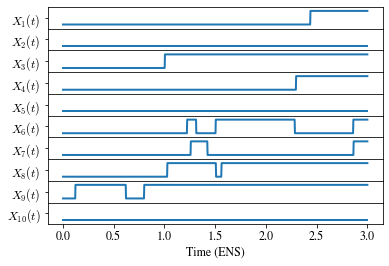

In [322]:
init_geno = np.eye(K)[np.zeros(L).astype(np.int)] # Initial genotype
g_t = evolve_genotype(init_geno)
g_t = np.array([np.where(g_t[i])[1] for i in range(len(g_t))])
plot_genotype(g_t)

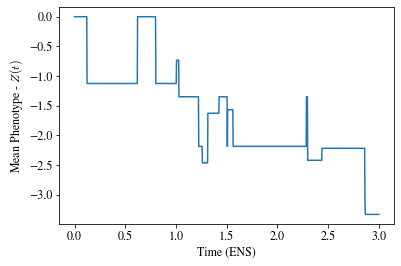

In [323]:
plot_phenotype(g_t, beta)

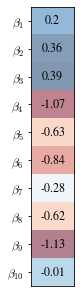

In [261]:
plt.figure(figsize=(1, 4))
plt.imshow(beta[:, 1:], cmap='RdBu', alpha=0.5, aspect='auto')
plt.xticks([])
plt.yticks(np.arange(L), ['$\\beta_{%d}$' % (i + 1) for i in range(L)])
for j in range(len(beta)):
    text = plt.text(0, j, np.round(beta[j, 1], 2),
                   ha="center", va="center", color="black")
plt.tight_layout(pad=0.2)
plt.savefig("./appendix_vis/fig1_b.svg")

# Moments of Mean Phenotype

In [376]:
n_replicates=100

#init_geno = np.eye(K)[np.random.choice(2, size=L, p=[0.9, 0.1]).astype(np.int)] # Initial genotype
init_geno = np.eye(K)[np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])]

res = []

for _ in  range(n_replicates):
    gt = evolve_genotype(init_geno)
    res.append(np.array([np.where(gt[i])[1] for i in range(len(gt))]))


<Figure size 432x288 with 0 Axes>

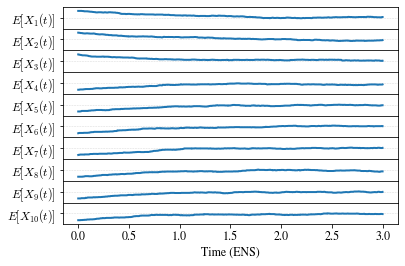

In [390]:
expected_genotype = np.zeros_like(res[0])
for i in range(n_replicates):
    expected_genotype += res[i]
    
plot_genotype(expected_genotype / n_replicates, fig_file="./appendix_vis/fig3a.svg", expectation=True)

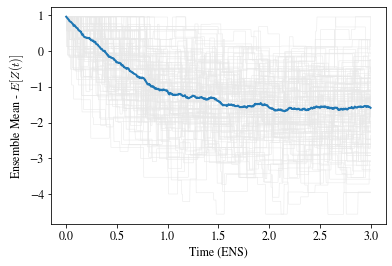

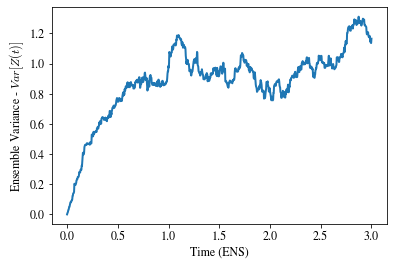

In [389]:
plot_ensemble_moments(res, beta, mean_fig_file="./appendix_vis/fig3b.svg", var_fig_file="./appendix_vis/fig3c.svg")

In [1]:
from Bio import Phylo
import pandas as pd
import numpy as np
from gp_models.gp_models import GaussianProcessModel, NeutralModel, OU, BM
%load_ext autoreload
%autoreload 2

In [19]:
erv_data = pd.read_csv("ancient_erv_analysis/data/3_q_traits/2_simulated_sequences/segment_7916_8695/traits.csv", index_col=0).T
erv_tree = Phylo.read("ancient_erv_analysis/metadata/segment_trees/paml_inferred/segment_7916_8695.nwk", "newick")

nm = NeutralModel(erv_data['gc_content'], erv_tree, fixed_params={'u': 1.37, 'Zeq': 0.36, 'sigma_eq': 0.000288})
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 131.79868019120283,
 'DOF': 2,
 'AIC': -259.59736038240567,
 'AIC.c': -259.27303605808135,
 'BIC': -256.2196014741778,
 'Parameters': {'Z0': 0.45064921905129823,
  'Zeq': 0.36,
  'Psi': 0.001466726654975338,
  'sigma_eq': 0.000288,
  'u': 1.37}}

In [36]:
nm = NeutralModel(erv_data['gc_content'], erv_tree, fixed_params={'u': 1.34, 'Zeq': 0.44, 'sigma_eq': 0.00031})
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 133.3038790819269,
 'DOF': 2,
 'AIC': -262.6077581638538,
 'AIC.c': -262.2834338395295,
 'BIC': -259.22999925562596,
 'Parameters': {'Z0': 0.4286605308041588,
  'Zeq': 0.44,
  'Psi': 0.0013519381029283538,
  'sigma_eq': 0.00031,
  'u': 1.34}}

In [37]:
nm = NeutralModel(erv_data['gc_content'], erv_tree, fixed_params={'u': 1.34})
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 134.25707429348367,
 'DOF': 4,
 'AIC': -260.51414858696734,
 'AIC.c': -259.37129144411017,
 'BIC': -253.7586307705116,
 'Parameters': {'Z0': 0.4297984876708193,
  'Zeq': 0.4359537231454264,
  'Psi': 9.99999997437784e-13,
  'sigma_eq': 0.0025563088548873187,
  'u': 1.34}}

In [38]:
nm = NeutralModel(erv_data['gc_content'], erv_tree)
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 134.90977876586916,
 'DOF': 5,
 'AIC': -259.8195575317383,
 'AIC.c': -258.0548516493854,
 'BIC': -251.37516026116865,
 'Parameters': {'Z0': 0.4298567820580272,
  'Zeq': 0.4341898649481175,
  'Psi': 9.999999960041972e-13,
  'sigma_eq': 0.0012508851221227223,
  'u': 2.0}}

In [41]:
ou = OU(erv_data['gc_content'], erv_tree)
ou.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 139.7563195304113,
 'DOF': 4,
 'AIC': -271.5126390608226,
 'AIC.c': -270.36978191796544,
 'BIC': -264.7571212443669,
 'Parameters': {'Z0': 0.4294136384780781,
  'Zeq': 0.4320629759227744,
  'sigma': 0.003293928936528404,
  'alpha': 18.468859845082363}}

In [44]:
ou = OU(erv_data['gc_content'], erv_tree, equilibrium_z0=True)
ou.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 139.7548962775069,
 'DOF': 3,
 'AIC': -273.5097925550138,
 'AIC.c': -272.8431258883471,
 'BIC': -268.443154192672,
 'Parameters': {'Zeq': 0.43201396720676144,
  'sigma': 0.003283819918767566,
  'alpha': 18.382295122779674}}

In [43]:
bm = BM(erv_data['gc_content'], erv_tree)
bm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 131.68912822706005,
 'DOF': 2,
 'AIC': -259.3782564541201,
 'AIC.c': -259.0539321297958,
 'BIC': -256.00049754589224,
 'Parameters': {'Z0': 0.43090571681745277, 'sigma': 0.0015004967278711004}}

In [169]:
import sys
sys.path.insert(0, "ancient_erv_analysis")
from compute_q_traits import calculate_gc_content

def plot_nll(segment):

    erv_data = pd.read_csv(f"ancient_erv_analysis/data/3_q_traits/2_simulated_sequences/{segment}/traits.csv", index_col=0).T
    erv_tree = Phylo.read(f"ancient_erv_analysis/metadata/segment_trees/paml_inferred/{segment}.nwk", "newick")
    
    with open(f"ancient_erv_analysis/data/2_simulated_sequences/{segment}/alignment.root", "r") as algn_f:
        root_seq = str(algn_f.read()).strip()
        
    true_z0 = calculate_gc_content(root_seq)
    
    nm = NeutralModel(erv_data['gc_content'], erv_tree, fixed_params={'u': 1.34, 'Zeq': 0.44, 'sigma_eq': 0.2464/len(root_seq)})
    nm.fit()

    z0 = np.linspace(0., 1., 100)
    L = 800

    psi = (1./L)*(0.44 + z0 -2.*z0*0.44)

    nll = []

    for i in range(100):
        nm.z0 = z0[i]
        nm.psi = psi[i]
        nll.append(nm.nll())

    plt.plot(z0, nll)
    plt.axvline(true_z0, c='red', ls='--', label='True Z0')
    plt.xlabel("Z0")
    plt.ylabel("NLL")
    plt.title(f"GC Content - {segment}")
    plt.legend()
    plt.show()

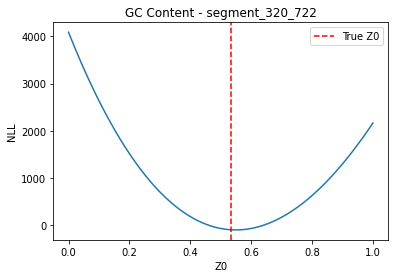

In [171]:
plot_nll('segment_320_722')

In [161]:
res_geiger = pd.read_csv("ancient_erv_analysis/geiger_inference/Simulated Sequences.csv", index_col=0)
res_python = pd.read_csv("gp_models/model_fit_results/simulated_seq_paml_inf_tree.csv", index_col=0)
res_ouch = pd.read_csv("ancient_erv_analysis/ouch_inference/Simulated Sequences.csv", index_col=0)

In [162]:
res_python = res_python.loc[res_python['Model'].isin(['BM', 'OU (Z0=Zeq)']), ['Trait', 'Sequence', 'Model', 'Log-likelihood', 'Corrected AIC', 'Z0']]

res_python['Trait'] = res_python['Trait'].replace({'gc_content': 'GC Content', 'A_percent':'Percent of A', 
                       'longest_ORF': 'Longest ORF', 'longest_ORF_alan': 'Longest ORF (Alan)'})
res_python['Model'] = res_python['Model'].replace({'OU (Z0=Zeq)': 'OU'})
res_python.columns = ['trait', 'segment', 'Model', 'loglik', 'aicc', 'z0']

res_python=pd.DataFrame(res_python.pivot(index=['trait','segment'], columns='Model', values=['loglik', 'aicc', 'z0']).to_records())
res_python.columns=['trait', 'segment', 'BM_loglik', 'OU_loglik', 'BM_aicc', 'OU_aicc', 'BM_z0', 'OU_z0']
res_python = res_python.sort_values(['segment', 'trait'])
res_python

,trait,segment,BM_loglik,OU_loglik,BM_aicc,OU_aicc,BM_z0,OU_z0
0,GC Content,segment_10270_10563,117.052026,117.156192,-229.761194,-227.606502,0.445244,0.446803
6,Longest ORF,segment_10270_10563,64.678852,74.893528,-125.014847,-143.081174,0.239975,0.198909
12,Longest ORF (Alan),segment_10270_10563,-152.442322,-147.123615,309.227501,300.953113,64.831010,43.895667
18,Percent of A,segment_10270_10563,122.320980,123.334298,-240.299104,-239.962714,0.255779,0.259193
1,GC Content,segment_11196_11705,120.667773,126.629818,-237.002212,-246.573923,0.405969,0.421714
7,Longest ORF,segment_11196_11705,37.044146,77.204860,-69.754958,-147.724006,0.162359,0.141444
13,Longest ORF (Alan),segment_11196_11705,-204.001424,-167.547309,412.336181,341.780332,69.251633,57.071273
19,Percent of A,segment_11196_11705,132.446367,139.671686,-260.559401,-272.657658,0.276056,0.271804
2,GC Content,segment_11935_12275,99.900996,115.603261,-195.449050,-224.479250,0.479073,0.482101
8,Longest ORF,segment_11935_12275,22.265511,72.250505,-40.178080,-137.773738,0.193667,0.196897


In [163]:
res_geiger = res_geiger[['trait', 'segment', 'BM_loglik', 'OU_loglik', 'BM_aicc', 'OU_aicc', 'BM_z0', 'OU_z0']]
res_geiger = res_geiger.sort_values(['segment', 'trait'])
res_geiger

,trait,segment,BM_loglik,OU_loglik,BM_aicc,OU_aicc,BM_z0,OU_z0
1,GC Content,segment_10270_10563,117.052026,117.156192,-229.761194,-227.606502,0.445244,0.446803
2,Longest ORF,segment_10270_10563,64.678852,74.893528,-125.014847,-143.081174,0.239975,0.198909
4,Longest ORF (Alan),segment_10270_10563,-152.442321,-147.123615,309.227499,300.953112,64.830701,43.896081
3,Percent of A,segment_10270_10563,122.320980,123.334298,-240.299104,-239.962714,0.255779,0.259193
5,GC Content,segment_11196_11705,120.667773,126.629819,-237.002212,-246.573924,0.405969,0.421714
6,Longest ORF,segment_11196_11705,37.044146,77.204860,-69.754958,-147.724006,0.162359,0.141446
8,Longest ORF (Alan),segment_11196_11705,-204.000881,-167.546866,412.335096,341.779447,69.223404,57.081638
7,Percent of A,segment_11196_11705,132.446367,139.671687,-260.559401,-272.657660,0.276056,0.271803
9,GC Content,segment_11935_12275,99.900996,115.603261,-195.449050,-224.479250,0.479073,0.482101
10,Longest ORF,segment_11935_12275,22.265511,72.250506,-40.178081,-137.773740,0.193631,0.196895


In [164]:
res_ouch.columns = ['segment', 'trait', 'BM_loglik_ouch', 'BM_aicc_ouch', 'BM_z0_ouch', 'OU_loglik_ouch',
       'OU_aicc_ouch', 'OU_z0_ouch']
res_ouch = res_ouch[['trait', 'segment', 'BM_loglik_ouch', 'OU_loglik_ouch', 'BM_aicc_ouch', 
                     'OU_aicc_ouch', 'BM_z0_ouch', 'OU_z0_ouch']]
res_ouch = res_ouch.sort_values(['segment', 'trait'])
res_ouch

,trait,segment,BM_loglik_ouch,OU_loglik_ouch,BM_aicc_ouch,OU_aicc_ouch,BM_z0_ouch,OU_z0_ouch
1,GC Content,segment_10270_10563,52.354190,92.237393,-100.365523,-177.768904,0.458465,0.440455
2,Longest ORF,segment_10270_10563,43.108691,71.664211,-81.874525,-136.622540,0.163735,0.197643
4,Longest ORF (Alan),segment_10270_10563,-178.317583,-152.548884,360.978024,311.803651,36.024982,44.318450
3,Percent of A,segment_10270_10563,70.486231,105.481110,-136.629605,-204.256337,0.251700,0.263966
5,GC Content,segment_11196_11705,-11.216380,117.735191,26.766094,-228.784668,0.430227,0.422105
6,Longest ORF,segment_11196_11705,13.529603,75.869520,-22.725873,-145.053326,0.172103,0.142000
8,Longest ORF (Alan),segment_11196_11705,-292.833114,-178.427553,589.999562,363.540821,78.366284,58.089240
7,Percent of A,segment_11196_11705,9.258414,127.877803,-14.183494,-249.069891,0.276225,0.268811
9,GC Content,segment_11935_12275,-6.400472,106.336656,17.153884,-205.946039,0.474791,0.481097
10,Longest ORF,segment_11935_12275,-32.087691,66.190941,68.528322,-125.654610,0.169434,0.197115


In [211]:
m_res = pd.merge(res_geiger, res_python, on=['trait', 'segment'], suffixes=('_geiger', '_python')).merge(res_ouch, on=['trait', 'segment'])
comp_res = m_res[['trait', 'segment'] + sorted(m_res.columns[2:])] 
comp_res.to_csv("comparison_table.csv", index=False)
comp_res

,trait,segment,BM_aicc_geiger,BM_aicc_ouch,BM_aicc_python,BM_loglik_geiger,BM_loglik_ouch,BM_loglik_python,BM_z0_geiger,BM_z0_ouch,BM_z0_python,OU_aicc_geiger,OU_aicc_ouch,OU_aicc_python,OU_loglik_geiger,OU_loglik_ouch,OU_loglik_python,OU_z0_geiger,OU_z0_ouch,OU_z0_python
0,GC Content,segment_10270_10563,-229.761194,-100.365523,-229.761194,117.052026,52.354190,117.052026,0.445244,0.458465,0.445244,-227.606502,-177.768904,-227.606502,117.156192,92.237393,117.156192,0.446803,0.440455,0.446803
1,Longest ORF,segment_10270_10563,-125.014847,-81.874525,-125.014847,64.678852,43.108691,64.678852,0.239975,0.163735,0.239975,-143.081174,-136.622540,-143.081174,74.893528,71.664211,74.893528,0.198909,0.197643,0.198909
2,Longest ORF (Alan),segment_10270_10563,309.227499,360.978024,309.227501,-152.442321,-178.317583,-152.442322,64.830701,36.024982,64.831010,300.953112,311.803651,300.953113,-147.123615,-152.548884,-147.123615,43.896081,44.318450,43.895667
3,Percent of A,segment_10270_10563,-240.299104,-136.629605,-240.299104,122.320980,70.486231,122.320980,0.255779,0.251700,0.255779,-239.962714,-204.256337,-239.962714,123.334298,105.481110,123.334298,0.259193,0.263966,0.259193
4,GC Content,segment_11196_11705,-237.002212,26.766094,-237.002212,120.667773,-11.216380,120.667773,0.405969,0.430227,0.405969,-246.573924,-228.784668,-246.573923,126.629819,117.735191,126.629818,0.421714,0.422105,0.421714
5,Longest ORF,segment_11196_11705,-69.754958,-22.725873,-69.754958,37.044146,13.529603,37.044146,0.162359,0.172103,0.162359,-147.724006,-145.053326,-147.724006,77.204860,75.869520,77.204860,0.141446,0.142000,0.141444
6,Longest ORF (Alan),segment_11196_11705,412.335096,589.999562,412.336181,-204.000881,-292.833114,-204.001424,69.223404,78.366284,69.251633,341.779447,363.540821,341.780332,-167.546866,-178.427553,-167.547309,57.081638,58.089240,57.071273
7,Percent of A,segment_11196_11705,-260.559401,-14.183494,-260.559401,132.446367,9.258414,132.446367,0.276056,0.276225,0.276056,-272.657660,-249.069891,-272.657658,139.671687,127.877803,139.671686,0.271803,0.268811,0.271804
8,GC Content,segment_11935_12275,-195.449050,17.153884,-195.449050,99.900996,-6.400472,99.900996,0.479073,0.474791,0.479073,-224.479250,-205.946039,-224.479250,115.603261,106.336656,115.603261,0.482101,0.481097,0.482101
9,Longest ORF,segment_11935_12275,-40.178081,68.528322,-40.178080,22.265511,-32.087691,22.265511,0.193631,0.169434,0.193667,-137.773740,-125.654610,-137.773738,72.250506,66.190941,72.250505,0.196895,0.197115,0.196897


# Plotting results

In [252]:
df = pd.read_csv("gp_models/model_fit_results/true_seq_paml_inf_tree.csv", index_col=0)
df = df.loc[df['Trait'] != 'longest_ORF_alan']
df['Absolute Relative Error'] = np.abs((df['Z0'] - df['True Z0']) / df['True Z0'])
df['Relative Error']= (df['Z0'] - df['True Z0']) / df['True Z0']
df

,Trait,Sequence,Model,Log-likelihood,Corrected AIC,Pairwise Divergence Error,LOCO MSE,Z0,True Z0,Zeq,Absolute Relative Error,Relative Error
0,gc_content,segment_8938_9248,NeutralModel,105.733804,-199.532125,0.001909,0.036851,0.309484,NaN,0.390498,NaN,NaN
1,gc_content,segment_8938_9248,NeutralModel (fixed u=1.34),105.446528,-201.643056,0.001894,0.036246,0.308870,NaN,0.375389,NaN,NaN
2,gc_content,segment_8938_9248,"NeutralModel (fixed u=1.34, Z_eq=0.44)",105.446528,-204.165784,0.001894,0.036246,0.308870,NaN,0.375389,NaN,NaN
3,gc_content,segment_8938_9248,"NeutralModel (fixed u=1.34, Z_eq=0.44, sigma_e...",103.683404,-203.013866,0.001875,0.035960,0.334150,NaN,0.316989,NaN,NaN
4,gc_content,segment_8938_9248,OU,104.990929,-200.731857,0.001926,NaN,0.328601,NaN,-6.227330,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
134,A_percent,segment_7916_8695,"NeutralModel (fixed u=1.34, Z_eq=0.28)",137.680484,-268.694301,0.000270,0.005999,0.258088,NaN,0.328649,NaN,NaN
135,A_percent,segment_7916_8695,"NeutralModel (fixed u=1.34, Z_eq=0.28, sigma_e...",137.586851,-270.849378,0.000261,0.005708,0.263026,NaN,0.311410,NaN,NaN
136,A_percent,segment_7916_8695,OU,137.142460,-265.142063,0.000279,0.005422,0.265151,NaN,0.566440,NaN,NaN
137,A_percent,segment_7916_8695,OU (Z0=Zeq),136.809338,-266.952010,0.000276,0.005064,0.271974,NaN,0.271974,NaN,NaN


In [215]:
df['Model'].unique()

array(['NeutralModel', 'NeutralModel (fixed u=1.34)',
       'NeutralModel (fixed u=1.34, Z_eq=0.44)',
       'NeutralModel (fixed u=1.34, Z_eq=0.44, sigma_eq=0.2464/L)', 'OU',
       'OU (Z0=Zeq)', 'BM', 'NeutralModel (fixed u=1.34, Z_eq=0.28)',
       'NeutralModel (fixed u=1.34, Z_eq=0.28, sigma_eq=0.2016/L)'],
      dtype=object)

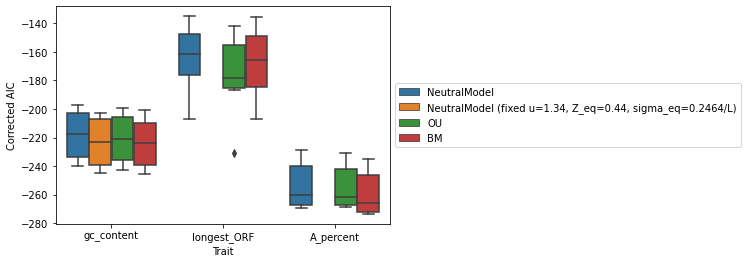

In [256]:
import seaborn as sns
mdf = df.loc[df['Model'].isin(['OU', 'BM', 'NeutralModel', 'NeutralModel (fixed u=1.34, Z_eq=0.44, sigma_eq=0.2464/L)'])]
ax = sns.boxplot(x="Trait", y="Corrected AIC", hue="Model", data=mdf)
#plt.axhline(y=0., ls='--', c='r', zorder=1)
#plt.ylim([-.1, .1])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [224]:
mdf

,Trait,Sequence,Model,Log-likelihood,Corrected AIC,Pairwise Divergence Error,LOCO MSE,Z0,True Z0,Zeq,Absolute Relative Error
0,gc_content,segment_8938_9248,NeutralModel,104.335955,-196.736427,0.001236,0.004452,0.316882,0.315113,0.407550,0.005616
4,gc_content,segment_8938_9248,OU,111.139659,-213.029319,0.000498,428.306183,-0.109981,0.315113,0.374700,1.349022
6,gc_content,segment_8938_9248,BM,98.439445,-192.525949,0.002143,0.007242,0.347892,0.315113,0.347892,0.104024
7,longest_ORF,segment_8938_9248,NeutralModel,80.282403,-148.629323,0.004796,0.063968,0.189333,0.247588,0.203946,0.235292
9,longest_ORF,segment_8938_9248,OU,82.241273,-155.232545,0.003425,0.073464,0.190712,0.247588,0.196115,0.229720
11,longest_ORF,segment_8938_9248,BM,76.725661,-149.098380,0.007306,0.067483,0.194825,0.247588,0.194825,0.213108
12,A_percent,segment_8938_9248,NeutralModel,110.157463,-208.379443,0.000799,0.003954,0.373530,0.366559,0.296098,0.019015
16,A_percent,segment_8938_9248,OU,114.618308,-219.986616,0.000416,0.011291,0.778658,0.366559,0.324558,1.124233
18,A_percent,segment_8938_9248,BM,104.026755,-203.700568,0.001512,0.006157,0.347314,0.366559,0.347314,0.052502
24,gc_content,segment_11196_11705,NeutralModel,124.985737,-238.153293,0.000447,0.003649,0.385816,0.398039,0.459722,0.030708


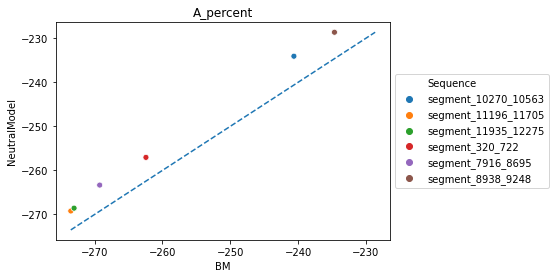

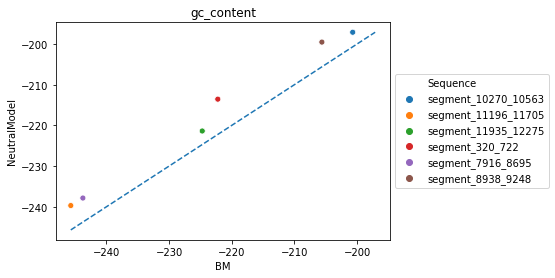

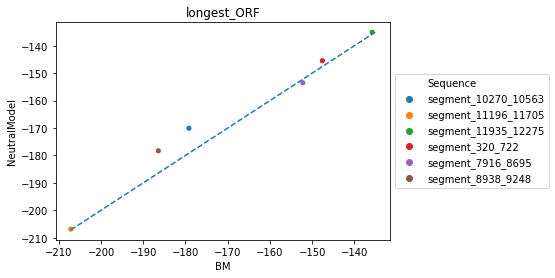

In [220]:
mdf = df.pivot(index=['Trait', 'Sequence'], columns='Model', values='Corrected AIC').reset_index()

x_model = 'BM'
y_model = 'NeutralModel'

for t in mdf['Trait'].unique():
    t_mdf = mdf.loc[mdf['Trait'] == t]
    ax = sns.scatterplot(data=t_mdf, x=x_model, y=y_model, hue="Sequence")
    x = np.linspace(t_mdf[[x_model, y_model]].min().min(), t_mdf[[x_model, y_model]].max().max(), 1000)
    plt.plot(x, x, ls='--')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(t)
    plt.show()

In [125]:
mdf

Model,Trait,Sequence,BM,NeutralModel,NeutralModel (fixed u=1.34),"NeutralModel (fixed u=1.34, Z_eq=0.28)","NeutralModel (fixed u=1.34, Z_eq=0.28, sigma_eq=0.2016/L)","NeutralModel (fixed u=1.34, Z_eq=0.44)","NeutralModel (fixed u=1.34, Z_eq=0.44, sigma_eq=0.2464/L)",OU,OU (Z0=Zeq)
0,A_percent,segment_10270_10563,-240.299104,-236.156428,-239.125620,-241.631859,-242.165692,NaN,NaN,-238.155014,-239.962714
1,A_percent,segment_11196_11705,-260.559401,-260.460605,-261.707493,-264.198249,-264.212826,NaN,NaN,-270.806524,-272.657658
2,A_percent,segment_11935_12275,-163.443472,-165.499878,-166.388284,-168.911011,-167.572648,NaN,NaN,-216.451241,-218.973969
3,A_percent,segment_320_722,-165.717002,-168.507561,-166.815893,-169.322132,-171.677691,NaN,NaN,-204.136531,-203.862245
4,A_percent,segment_7916_8695,-292.707263,-291.202553,-292.669058,-295.145249,-295.740834,NaN,NaN,-288.133289,-290.609479
5,A_percent,segment_8938_9248,-203.700568,-208.379443,-209.275488,-211.798215,-210.165295,NaN,NaN,-219.986616,-218.744567
6,gc_content,segment_10270_10563,-229.761194,-224.579538,-227.033880,NaN,NaN,-229.540119,-230.559703,-226.409166,-227.606502
7,gc_content,segment_11196_11705,-237.002212,-238.153293,-239.288020,NaN,NaN,-241.778776,-241.743548,-249.170825,-246.573923
8,gc_content,segment_11935_12275,-195.449050,-196.537843,-197.617801,NaN,NaN,-200.140528,-199.387711,-222.125995,-224.479250
9,gc_content,segment_320_722,-216.657342,-223.740467,-225.114509,NaN,NaN,-227.620747,-226.554716,-228.554393,-214.267247


In [127]:
mdf['Trait'].unique()

array(['gc_content', 'longest_ORF', 'A_percent', 'longest_ORF_alan'],
      dtype=object)

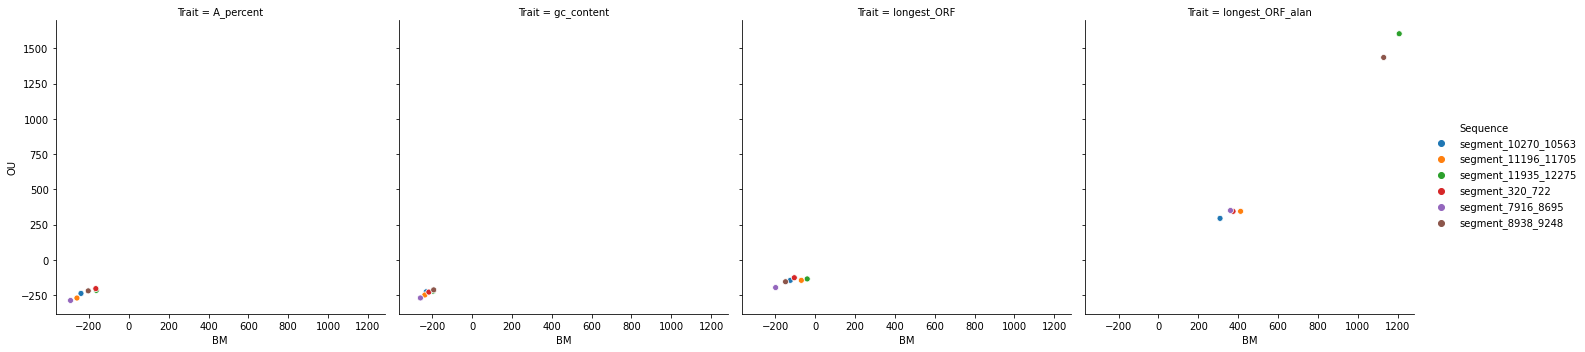

In [131]:
sns.relplot(
    data=mdf, x="BM", y="OU",
    col="Trait", hue="Sequence",
    kind="scatter"
)

In [208]:
erv_data = pd.read_csv("ancient_erv_analysis/data/3_q_traits/2_simulated_sequences/segment_11935_12275/traits.csv", index_col=0).T
erv_tree = Phylo.read("ancient_erv_analysis/metadata/segment_trees/paml_inferred/segment_11935_12275.nwk", "newick")

m = BM((erv_data['longest_ORF_alan'] - erv_data['longest_ORF_alan'].mean()) / erv_data['longest_ORF_alan'].std(), erv_tree)
m.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': -107.2266888153429,
 'Pairwise divergence loss': 202.63798642082108,
 'DOF': 2,
 'AIC': 218.4533776306858,
 'AIC.c': 218.80631880715637,
 'BIC': 221.67521345597424,
 'Parameters': {'Z0': 0.19154655738661963, 'sigma': 638.2349499183551}}

In [209]:
0.19154655738661963*erv_data['longest_ORF_alan'].std() + erv_data['longest_ORF_alan'].mean()

51.33550893989094